# Imports

In [1]:
from library.dataPreprocessLib import *
from library.resultsLib import *
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import os

# Data Preprocessing

## Feature Selection and Loading Data

In [2]:
# name = "prantika_bus_stand"
# name = "junction_mall"
name = "54ft_road"
# name = "dvc_more"
#name = "station"

In [3]:
parent_dir = r"../data/54ft/"
train_df_name = r"54ft_train.csv"
test_df_name = f"{name}_test_split.csv"

In [4]:
poi_column = 'Is_Congestion'
output_result_filename = f"{poi_column}_test_result_{name}_zone.csv"

In [5]:
#feature # binding
F=\
    {1:'stay_duration', #f1
     2:'mfcc0',3:'mfcc1',4:'mfcc2',5:'mfcc3',6:'mfcc4', #f2,f3,f4,f5,f6
     7:'wifi_count', 8:'edge_wifi_count', #f7,f8
     9:'RSI', #f9
     10:'human_made', 11:'natural_land',12:'road_exist_percent',13:'highly_populated_poi_exist'#f10,f11,f12,f13
    }



feature_names=[F[e] for e in [2,11,10,9,12,8,6,1]]

### Training Data

In [6]:
train_csv_df = pd.read_csv(os.path.join(parent_dir, train_df_name))
train_df = train_csv_df[feature_names+[poi_column]]
train_df.head()

,mfcc0,natural_land,human_made,RSI,road_exist_percent,edge_wifi_count,mfcc4,stay_duration,Is_Congestion
0,39.288479,0.636805,0.111232,0.000000,0.251963,0.000000,7.541212,6,0
1,42.699326,0.666587,0.124869,2.715045,0.208544,0.015468,8.094163,10,0
2,70.480301,0.743668,0.100360,2.422751,0.155972,0.027800,6.575349,130,0
3,76.429749,0.730013,0.100911,3.040420,0.169076,0.000000,7.560440,13,0
4,71.429588,0.487688,0.117394,1.780860,0.183064,0.002818,8.189456,9,0


### Testing Data

In [7]:
test_csv_df = pd.read_csv(os.path.join(parent_dir, test_df_name))
test_df = test_csv_df[feature_names+[poi_column]]
test_df.head()

,mfcc0,natural_land,human_made,RSI,road_exist_percent,edge_wifi_count,mfcc4,stay_duration,Is_Congestion
0,69.060471,0.500080,0.228177,16.869160,0.271135,0.011578,-3.515217,11,0
1,86.484085,0.459261,0.200089,1.625491,0.268251,0.000000,-1.677307,2,0
2,73.721138,0.459994,0.254925,1.346294,0.285081,0.037472,-1.502949,8,0
3,48.402252,0.510915,0.218173,1.388512,0.270912,0.047988,-3.286928,8,0
4,68.970947,0.489662,0.228172,1.421124,0.277140,0.036448,-5.212214,13,0


### Seperating target column and input columns

In [8]:
X = train_df[feature_names].copy()
y = train_df[poi_column].copy()

## Using SMOTE

In [9]:
smote = SMOTE()

In [10]:
X_resampled, y_resampled = smote.fit_sample(X, y)
print(X.shape)
print(y.shape)
print(X_resampled.shape)
print(y_resampled.shape)

(2480, 8)
(2480,)
(4492, 8)
(4492,)


## Categorical data Transformation

### For train data

In [11]:
train_data = X_resampled.copy()
train_labels = y_resampled.copy()

### For test data

In [12]:
test_data = test_df[feature_names].values
test_labels = test_df[poi_column].values

# Training

In [13]:
model = RandomForestClassifier(n_estimators=20,max_depth=8)
model.fit(train_data, train_labels)
train_predictions = model.predict(train_data) # for training performance stat

# Testing

In [14]:
assert test_data.shape[1] == train_data.shape[1]
test_predictions = model.predict(test_data)

# Performance Stat

## Training Performance

In [15]:
get_performance_stats("train", train_labels, train_predictions)

For train: 
	Accuracy: 0.9102849510240427
	Precision: 0.911183609943874
	Recall: 0.9102849510240427
	F1 score: 0.9102359052313034
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      2246
           1       0.89      0.93      0.91      2246

    accuracy                           0.91      4492
   macro avg       0.91      0.91      0.91      4492
weighted avg       0.91      0.91      0.91      4492



## Testing Performance

In [16]:
get_performance_stats("test", test_labels, test_predictions)

For test: 
	Accuracy: 0.9081632653061225
	Precision: 0.9028930253420049
	Recall: 0.9081632653061225
	F1 score: 0.9053557334536024
              precision    recall  f1-score   support

           0       0.95      0.96      0.95        90
           1       0.43      0.38      0.40         8

    accuracy                           0.91        98
   macro avg       0.69      0.67      0.68        98
weighted avg       0.90      0.91      0.91        98



### Confusion Matrix

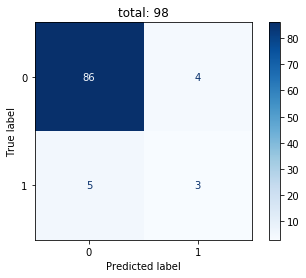

In [18]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
disp = plot_confusion_matrix(model, test_data, test_labels, cmap=plt.cm.Blues)
disp.ax_.set_title(f'total: {len(test_data)}')
plt.show()

### Check & Save Predicitons

In [19]:
result_df = form_result_df(test_csv_df, test_predictions, poi_column)
result_df.head()

,instance_date,instance_start_time,instance_end_time,Prediction Is_Congestion
0,09/14/2019,12:36:15,12:36:26,0
1,09/14/2019,12:36:38,12:36:39,0
2,09/14/2019,17:16:49,17:16:56,0
3,09/14/2019,17:17:33,17:17:40,0
4,09/14/2019,17:18:04,17:18:19,0


In [20]:
result_df.to_csv(os.path.join(parent_dir, output_result_filename), index=False)

In [21]:
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [22]:
test_predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)